# K-means clustering to classify houses
First we import packages and the data. A .csv file was created from the .xlsx file.

In [126]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = pd.read_csv('Houses.csv')

print(data.tail())
print(len(data.index))
data_np = data.to_numpy()

      Monthly energy cost in winter ($)  Monthly energy cost in summer ($)
2995                         170.745893                         194.806422
2996                         174.176018                         197.728817
2997                         178.980150                         201.783254
2998                         175.090467                         201.454589
2999                         167.343184                         200.513348
3000


### Visualizing data
There are three apparent groups of houses in this data. Therefore it is logical to predict that k=3 will be good.

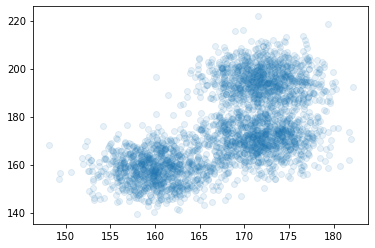

In [127]:
# visualizing data
plt.scatter(data['Monthly energy cost in winter ($)'], data['Monthly energy cost in summer ($)'], alpha = 0.1)


### The k-means algorithm
First, a 'cluster'-class is created, to handle the clusters and their points throughout the algorithm.

In [128]:
class Cluster:
    def __init__(self, centroid):
        self.centroid = centroid
        self.points = []

    def __str__(self) -> str:
        return 'Cluster with centroid: ' + np.array2string(self.centroid)

    def distance_to(self, point):
        # l2 norm
        sum = 0
        for idx in range(self.centroid.size):
            sum += (self.centroid[idx] - point[idx])**2
        return sum**0.5

        #l1 norm
        sum = 0
        for idx in range(self.centroid.size):
            sum += abs(self.centroid[idx] - point[idx])#**2
        return sum#**0.5
    
    def update_centroid(self):
        # check if empty
        if len(self.points) == 0:
            raise Exception('No points in cluster, should never happen')
        sum = 0
        for point in self.points:
            sum += point
        self.previous_centroid = self.centroid
        self.centroid = sum/len(self.points)

    def current_distortion(self):
        J = 0
        for point in self.points:
            J += self.distance_to(point)
        return J

    def clear_points(self):
        self.points = []

    def check_if_changed(self):
        # should be called right after assignment step
        return not np.array_equal(self.centroid, self.previous_centroid)

    def find_closest(self, points):
        closest = None
        min_dist = float('inf')
        for point in points:
            dist = self.distance_to(point)
            if dist < min_dist:
                closest = point
                min_dist = dist
        return closest

### The algorithm
For each given value of k, a k-means clustering algorithm is performed. Initially, k random centroids are picked from the data. Until the algorithm becomes terminal, if follows the following steps: `assignment`, `updating`, and `check terminal`. In `assignment`, all the points are assigned to the cluster which has the closest centroid. In `updating`, the new centroid for each cluster is calculated based on the points that belong to that cluster. If a cluster is empty, it 'steals' a point from a random non-empty cluster. Also, the distortion function is calculated here. In `check terminal`, each cluster is checked to see if its set of points is different from the last iterations set of points. If all clusters are unchanged, the algorithm has converged and is deemed terminal. Then, the distorions and the final clusters are saved for visualization.

In [129]:
ks = [2, 3, 4, 5, 6, 10]
Js = []
final_clusters = []
N_samples = len(data.index)

for k in ks:
    clusters = []
    # time-series of distorions:
    J_series = []
    # initialization, create random cluster centroids
    randos = np.random.choice(N_samples-1, k)
    for random in randos:
        clusters.append(Cluster(data_np[random]))

    # main loop
    terminal = False
    while not terminal:
        # Assignment
        print('assigning')
        for point in data_np:
            min_dist = float('inf')
            closest_cluster = None
            for cluster in clusters:
                dist_to_centroid = cluster.distance_to(point)
                if dist_to_centroid < min_dist:
                    closest_cluster = cluster
                    min_dist = dist_to_centroid
            closest_cluster.points.append(point)

        # Update and check distortion
        print('updating')
        J = 0
        for cluster in clusters:

            if len(cluster.points) == 0: # empty cluster, needs a new data point so that it can define a centroid
                # adding point
                found_cluster_to_steal_from = False
                cluster_to_steal_from = None
                while not found_cluster_to_steal_from:
                    other_cluster = random.choice(clusters)
                    if len(other_cluster.points) > 1: #dont want that cluster to become empty
                        found_cluster_to_steal_from = True
                        cluster_to_steal_from = other_cluster
                cluster.points.append(cluster_to_steal_from.points.pop())
            cluster.update_centroid()
            J += cluster.current_distortion()
        J = J/N_samples
        J_series.append(J)

        # check terminal
        found_change = False
        for cluster in clusters:
            if cluster.check_if_changed():
                found_change = True
                break
        if not found_change:
            terminal = True
        else:
            # clear old points
            for cluster in clusters:
                cluster.clear_points()

    #terminal
    Js.append(J_series)
    final_clusters.append(clusters.copy())
    



assigning
updating
assigning
updating
assigning
updating
assigning
updating
assigning
updating
assigning
updating
assigning
updating
assigning
updating
assigning
updating
assigning
updating
assigning
updating
assigning
updating
assigning
updating
assigning
updating
assigning
updating
assigning
updating
assigning
updating
assigning
updating
assigning
updating
assigning
updating
assigning
updating
assigning
updating
assigning
updating
assigning
updating
assigning
updating
assigning
updating
assigning
updating
assigning
updating
assigning
updating
assigning
updating
assigning
updating
assigning
updating
assigning
updating
assigning
updating
assigning
updating
assigning
updating
assigning
updating
assigning
updating
assigning
updating
assigning
updating
assigning
updating
assigning
updating
assigning
updating
assigning
updating
assigning
updating
assigning
updating
assigning
updating
assigning
updating
assigning
updating
assigning
updating
assigning
updating
assigning
updating
assigning
up

### Analysis and Visualization
The first plot contains the distortion function value for each k-value and iteration. Generally lower values of k converge after fewer iterations and have a larger distortion (which is expected, as if there are fewer centroids the closest one is probably further away than if there are more centroids). 
The following plots show scatterplots of the data where the points are color coded depending on which cluster they belong to. Also, the centroids are shown. The axes can be scaled the same or not by toggling one line in the code. If the scaling is the same, the voronoi diagrams of the data can be seen. If the l2-norm is chosen as the used norm, the cell borders are orthogonal to lines drawn between the centroids. If instead the manhattan norm is used, the borders become different. As expected from the data, the algorithm divides up the points in three fairly distinct groups for k=3. These groups probably correspond to houses with 3 distinct geographical locations or with 3 distinct heat-isolation and reflection qualities. As can be seen in the plots, adding additional clusters beyond 3 mostly just splits one of the three clear clusters into two or more, further reinforcing the theory that k=3 is a good choice.

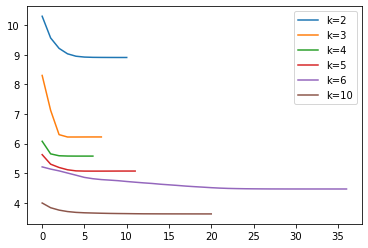

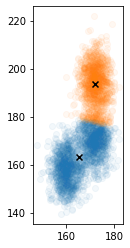

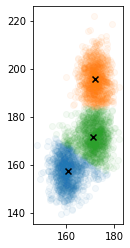

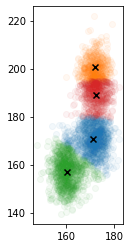

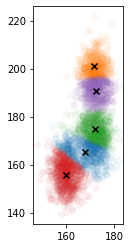

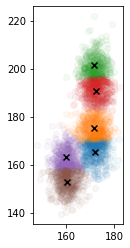

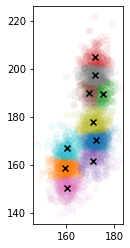

In [130]:
# analysis and visulaization
plt.figure()
for i, J in enumerate(Js):
    plt.plot(J, label='k={}'.format(ks[i]))
plt.legend()

for clusters in final_clusters:
    plt.figure()
    ax = plt.gca()
    ax.set_aspect('equal', adjustable='box') #toggle this line for true axis scaling or not.
    for cluster in clusters:
        x_series = [x[0] for x in cluster.points]
        y_series = [x[1] for x in cluster.points]
        plt.scatter(x_series, y_series, alpha=0.05)
        plt.scatter(cluster.centroid[0], cluster.centroid[1], marker='x', c='k')